In [1]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
import matplotlib.pyplot as plt
from GeneralModel import *

# Fitzhugh-Nagumo model

FitzHugh-Nagumo is a simplified version of the Hodgkin-Huxley models that captures behavior of a single neuron. 

The cartesian form of this model is:

\begin{align*}
\dot{V} &= V - \frac{V^3}{3} - w - I \\
\dot{w} &= \frac{1}{\tau}(V + a - bw)
\end{align*}

In [40]:
def FHFlow(t, x, params):
    I   = params["I"]
    a   = params["a"]
    b   = params["b"]
    tau = params["tau"]

    V, w = x[0], x[1]
    
    dV = V - V**3/3 - w + I
    dw = (V + a - b*w)/tau
    
    return np.array([dV, dw])

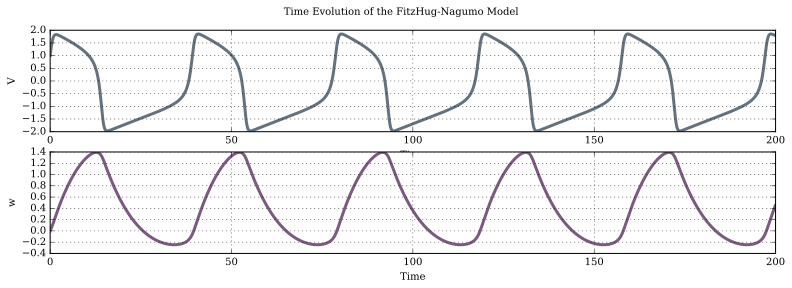

In [41]:
FH = GeneralModel(Name="FitzHug-Nagumo", tstart=0, tend=200, dt=0.1, a=0.7, b=0.8, tau=12.5, I=0.5)
FH.Initialize([1,0])
FH.Simulate(Flow=FHFlow, UpdateMethod="RungeKutta")
plt.rcParams["figure.figsize"] = (13, 4)
FH.PlotState(states={1:"V",2:"w"})

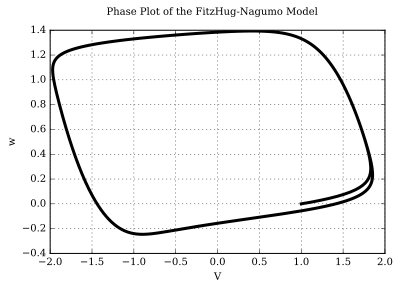

In [42]:
plt.rcParams["figure.figsize"] = (6, 4)
FH.PlotPhase(states={1:"V",2:"w"})

# Fitzhugh-Nagumo model in polar form

We convert the model to its polar form so that we can add Kuramoto like phase coupling to two or more oscillators. 

The polar form of this model is:

\begin{align*}
\dot{r}      &= r \cos^2\theta - \frac{r^3\cos^4\theta}{3} - r \sin\theta\cos\theta + I\cos\theta 
                + \frac{1}{\tau}\left(r\sin\theta\cos\theta + a\sin\theta - br\sin^2\theta\right)\\
\dot{\theta} &= \frac{1}{\tau} \left( 1+ \frac{a}{r\cos\theta} - b\tan\theta \right) - \frac{\dot{r}}{r}\tan\theta
\end{align*}

In [43]:
def FHPolarFlow(t, x, params):
    I   = params["I"]
    a   = params["a"]
    b   = params["b"]
    tau0 = params["tau"]
    
    r0, theta0 = x[0], x[1]
    
    dr0     = r0*np.cos(theta0)**2 - r0**3*np.cos(theta0)**4/3 - r0*np.sin(theta0)*np.cos(theta0) + I*np.cos(theta0) + \
            (r0*np.sin(theta0)*np.cos(theta0) + a*np.sin(theta0) - b*r0*np.sin(theta0)**2)/tau0
    dtheta0 = (1 + a/r0/np.cos(theta0) - b*np.tan(theta0))/tau0 - dr0/r0 * np.tan(theta0) 
    
    return np.array([dr0, dtheta0])


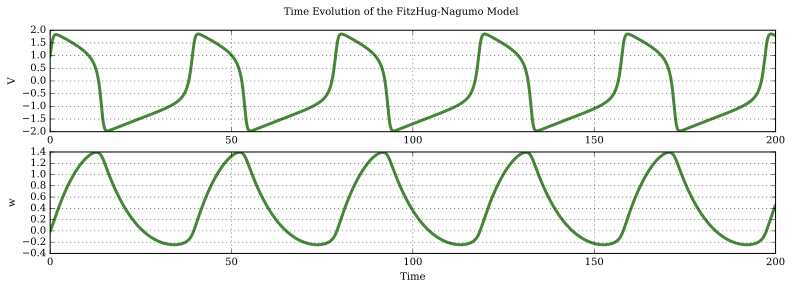

In [46]:
FHP = GeneralModel(Name="FitzHug-Nagumo", tstart=0, tend=200, dt=0.1, a=0.7, b=0.8, tau=12.5, I=0.5)
FHP.Initialize([1,0])
FHP.Simulate(Flow=FHPolarFlow, UpdateMethod="RungeKutta")
plt.rcParams["figure.figsize"] = (13, 4)
FHP.PolarPlotState(states={"theta":[1],"r":[0]},statelabels=["V","w"])

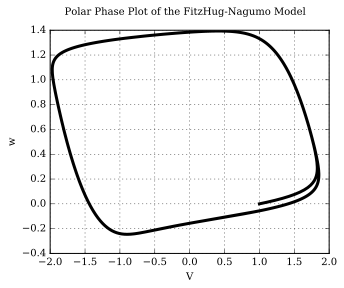

In [47]:
plt.rcParams["figure.figsize"] = (5, 4)
FH.PolarPlotPhase(states={"r":1,"theta":0},statelabels=["V","w"])

# Coupled Neurons

We now add a second neuron to the model and couple the two neurons using Kuramoto phase coupling. 

In [48]:
def FHKuramotoFlow(t, x, params):
    I    = params["I"]
    a    = params["a"]
    b    = params["b"]
    tau0 = params["tau"]
    tau1 = tau0+0.1
    k    = params["k"]
    
    r0, r1, theta0, theta1 = x[0], x[1], x[2], x[3]
    
    dr0     = r0*np.cos(theta0)**2 - r0**3*np.cos(theta0)**4/3 - r0*np.sin(theta0)*np.cos(theta0) + I*np.cos(theta0) + \
            (r0*np.sin(theta0)*np.cos(theta0) + a*np.sin(theta0) - b*r0*np.sin(theta0)**2)/tau0
    dr1     = r1*np.cos(theta1)**2 - r1**3*np.cos(theta1)**4/3 - r1*np.sin(theta1)*np.cos(theta1) + I*np.cos(theta1) + \
            (r1*np.sin(theta1)*np.cos(theta1) + a*np.sin(theta1) - b*r1*np.sin(theta1)**2)/tau1
    dtheta0 = (1 + a/r0/np.cos(theta0) - b*np.tan(theta0))/tau0 - dr0/r0 * np.tan(theta0) + k * np.sum([np.sin(tj-theta0) for tj in [theta0,theta1]])
    dtheta1 = (1 + a/r1/np.cos(theta1) - b*np.tan(theta1))/tau1 - dr1/r1 * np.tan(theta1) + k * np.sum([np.sin(tj-theta1) for tj in [theta0,theta1]])

    
    return np.array([dr0, dr1, dtheta0, dtheta1])

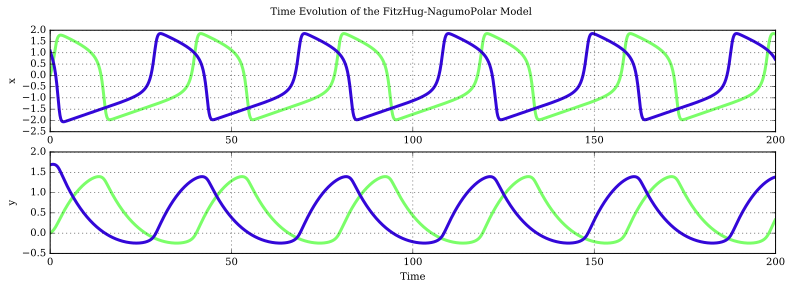

In [51]:
FHK = GeneralModel(Name="FitzHug-NagumoPolar", tstart=0, tend=200, dt=0.1, a=0.7, b=0.8, tau=12.5, I=0.5, k=0) 
FHK.Initialize([0.01, 2, 0, 1]) 
FHK.Simulate(Flow=FHKuramotoFlow, UpdateMethod="RungeKutta") 
plt.rcParams["figure.figsize"] = (13, 4)
FHK.PolarPlotState(states={"r":[0,1],"theta":[2,3]},statelabels=["x","y"],legend=["1","2"])

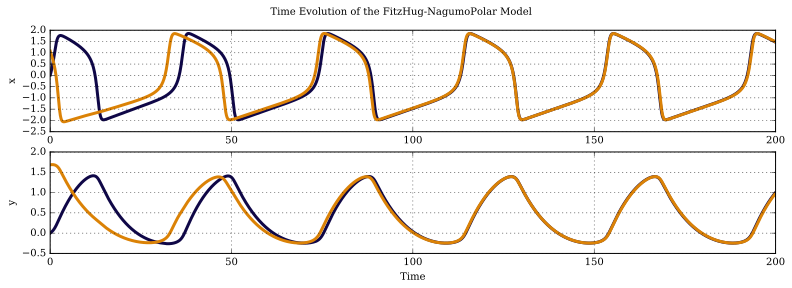

In [52]:
FHK2 = GeneralModel(Name="FitzHug-NagumoPolar", tstart=0, tend=200, dt=0.1, a=0.7, b=0.8, tau=12.5, I=0.5, k=0.015) 
FHK2.Initialize([0.01, 2, 0, 1]) 
FHK2.Simulate(Flow=FHKuramotoFlow, UpdateMethod="RungeKutta") 
plt.rcParams["figure.figsize"] = (13, 4)
FHK2.PolarPlotState(states={"r":[0,1],"theta":[2,3]},statelabels=["x","y"],legend=["1","2"])